In [13]:
import geopandas as gpd
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt


# 서울 전체 바운더리 생성
seoul_boundary = gpd.read_file(
    r"C:\Users\bsh96\Documents\GitHub\Smart_Coffee\seoul_boundary.shp"
)
seoul_boundary_union = seoul_boundary.unary_union
seoul_boundary_gdf = gpd.GeoDataFrame(
    geometry=[seoul_boundary_union], crs=seoul_boundary.crs
)


C:\Users\bsh96\AppData\Local\Temp\ipykernel_33824\3772235969.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  seoul_boundary_union = seoul_boundary.unary_union


In [14]:

######################################################################
# 100M 격자 데이터 불러오기
grid_100m = gpd.read_file(
    r"C:\Users\bsh96\Documents\GitHub\Smart_Coffee\real_final\data\grid_100M\grid_다사_100M.shp"
)

# 좌표계가 다르면 맞춰주기
if grid_100m.crs != seoul_boundary_gdf.crs:
    grid_100m = grid_100m.to_crs(seoul_boundary_gdf.crs)

# 서울 경계 내에 있는 그리드만 선택
grid_100m_in_seoul = gpd.overlay(grid_100m, seoul_boundary_gdf, how="intersection")

######################################################################



In [15]:
grid_100m_in_seoul.to_file("grid_100M_in_seoul.shp",encoding="utf-8")

In [16]:


def combine_population_data(start_year, end_year):
    dfs = []
    for year in range(start_year, end_year + 1):
        file_path = f"data/grid_100M/grid_2016_2024_pop/{year}년_인구_다사_100M.csv"
        df = pd.read_csv(file_path, encoding="utf-8")
        df = df[df["pop_type"] == "to_in_001"]
        df = df[["grid_code", "count"]]
        df = df.groupby("grid_code", as_index=False).sum()
        df = df.rename(columns={"count": f"count_{year}"})
        dfs.append(df)

    # Merge all years on grid_code
    df_merged = reduce(
        lambda left, right: pd.merge(left, right, on="grid_code", how="outer"), dfs
    )
    df_merged = df_merged.fillna(0)

    # Calculate mean count across years
    count_cols = [f"count_{year}" for year in range(start_year, end_year + 1)]
    df_merged["mean_count"] = df_merged[count_cols].mean(axis=1)

    # Merge with grid_100m_in_seoul
    result = grid_100m_in_seoul.merge(
        df_merged[["grid_code", "mean_count"]],
        left_on="GRID_100M_",
        right_on="grid_code",
        how="left",
    )
    result["mean_count"] = result["mean_count"].fillna(0)
    return result


pop_df = combine_population_data(2016, 2023)


C:\Users\bsh96\AppData\Local\Temp\ipykernel_33824\3366545784.py:23: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bsh96\AppData\Local\Temp\ipykernel_33824\3366545784.py:23: UserWarning: Glyph 50872 (\N{HANGUL SYLLABLE UL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bsh96\AppData\Local\Temp\ipykernel_33824\3366545784.py:23: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bsh96\AppData\Local\Temp\ipykernel_33824\3366545784.py:23: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bsh96\AppData\Local\Temp\ipykernel_33824\3366545784.py:23: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bsh96\AppData\Local\Temp\ipykernel_33824\3366545784.py:23: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missin

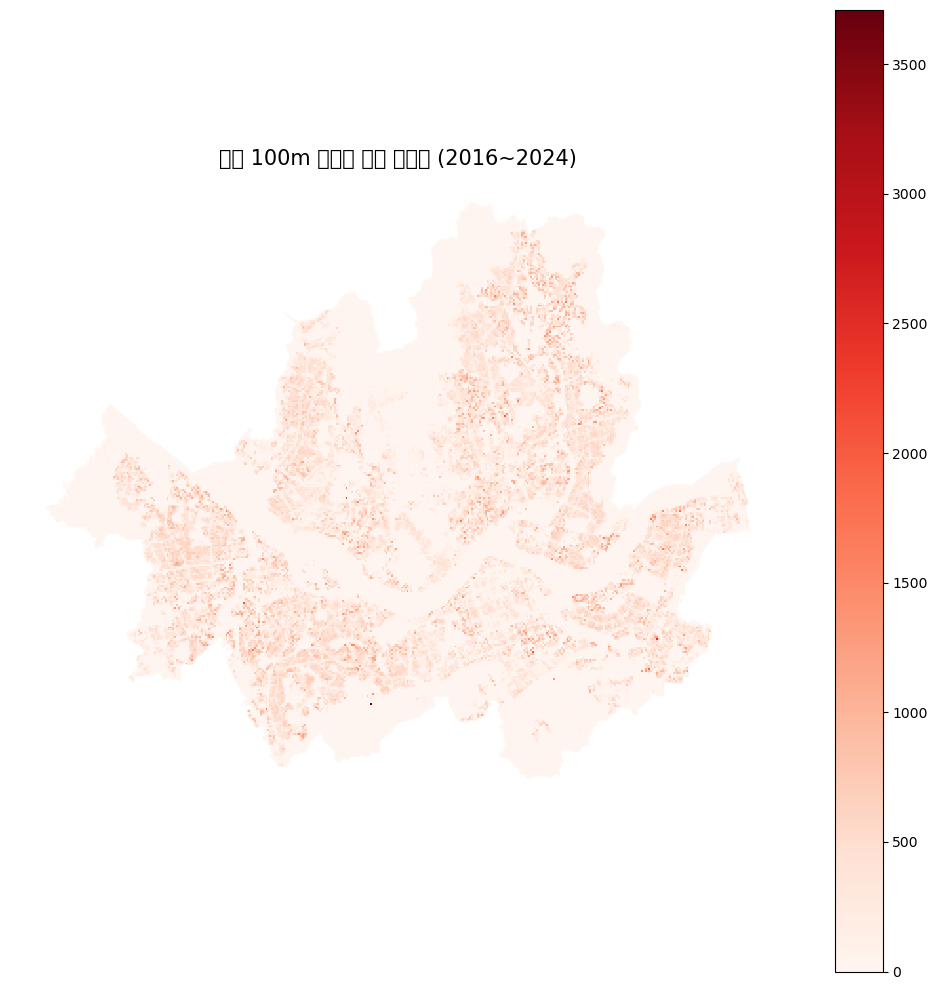

In [17]:

##############################################################################
grid_100m_pop_in_seoul = grid_100m_in_seoul.merge(
    pop_df[["grid_code", "mean_count"]],
    left_on="GRID_100M_",
    right_on="grid_code",
    how="left",
)

grid_100m_pop_in_seoul["mean_count"] = grid_100m_pop_in_seoul["mean_count"].fillna(0)
grid_100m_pop_in_seoul.to_file("grid_100m_pop_in_seoul.shp", encoding="utf-8")
###############################################################################
fig, ax = plt.subplots(figsize=(10, 10))
grid_100m_pop_in_seoul.plot(
    column="mean_count",
    cmap="Reds",
    linewidth=0,
    edgecolor=None,
    legend=True,
    ax=ax,
)
ax.set_axis_off()
plt.title("서울 100m 격자별 평균 인구수 (2016~2024)", fontsize=15)
plt.tight_layout()
plt.show()

In [18]:
# 카페 데이터 불러오기 및 GeoDataFrame 생성
cafe_df = pd.read_csv("data/cafe_open_at_2016_2024.csv", encoding="utf-8")
cafe_gdf = gpd.GeoDataFrame(
    cafe_df,
    geometry=gpd.points_from_xy(cafe_df["좌표정보x(epsg5174)"], cafe_df["좌표정보y(epsg5174)"]),
    crs="EPSG:5174"
)
# cafe_gdf의 좌표계를 grid_100m_pop_in_seoul과 맞추기
if cafe_gdf.crs != grid_100m_pop_in_seoul.crs:
    cafe_gdf = cafe_gdf.to_crs(grid_100m_pop_in_seoul.crs)

def is_alive(row):
    # type: (pd.Series) -> bool
    if row["영업상태명"] == "영업/정상":
        return True

    return False

# is_alive 컬럼 생성: 살아있으면 1, 폐업이면 0
cafe_gdf["is_alive"] = cafe_gdf.apply(lambda row: 1 if is_alive(row) else 0, axis=1)

# 각 카페가 속한 격자 찾기
cafe_with_grid = gpd.sjoin(cafe_gdf, grid_100m_pop_in_seoul[["GRID_100M_", "mean_count", "geometry"]], how="left", predicate="within")

# population 컬럼 추가
cafe_gdf["population"] = cafe_with_grid["mean_count"].values

cafe_gdf.to_file("cafe_with_population.shp", encoding="utf-8")

C:\Users\bsh96\AppData\Local\Temp\ipykernel_33824\1639648252.py:28: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  cafe_gdf.to_file("cafe_with_population.shp", encoding="utf-8")


살아있는 카페의 population 기술통계:
count    2804.000000
mean      212.153219
std       234.695677
min         0.000000
25%        31.125000
50%       150.937500
75%       309.343750
max      1917.250000
Name: population, dtype: float64

폐업한 카페의 population 기술통계:
count     595.000000
mean      203.971218
std       242.743040
min         0.000000
25%        16.875000
50%       129.625000
75%       296.375000
max      1917.250000
Name: population, dtype: float64


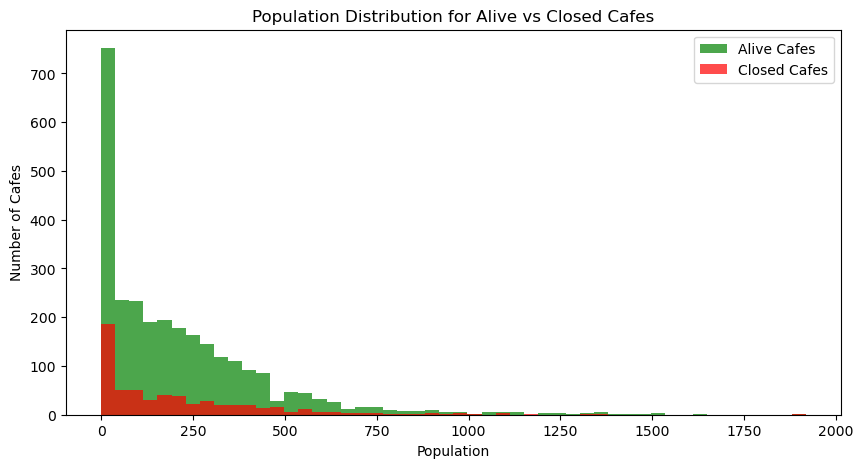

In [20]:


# 살아있는 카페와 폐업한 카페로 분리
alive_population = cafe_gdf.loc[cafe_gdf["is_alive"] == 1, "population"]
closed_population = cafe_gdf.loc[cafe_gdf["is_alive"] == 0, "population"]

# 기술통계 출력
print("살아있는 카페의 population 기술통계:")
print(alive_population.describe())
print("\n폐업한 카페의 population 기술통계:")
print(closed_population.describe())

plt.figure(figsize=(10, 5))
plt.hist(alive_population, bins=50, alpha=0.7, label="Alive Cafes", color="green")
plt.hist(closed_population, bins=50, alpha=0.7, label="Closed Cafes", color="red")
plt.xlabel("Population")
plt.ylabel("Number of Cafes")
plt.title("Population Distribution for Alive vs Closed Cafes")
plt.legend()
plt.show()



살아있는 카페의 population 기술통계:
count    2597.000000
mean      229.063390
std       235.794834
min         0.625000
25%        54.625000
50%       170.750000
75%       329.000000
max      1917.250000
Name: population, dtype: float64

폐업한 카페의 population 기술통계:
count     537.000000
mean      226.001629
std       245.585240
min         0.625000
25%        42.250000
50%       161.375000
75%       327.625000
max      1917.250000
Name: population, dtype: float64


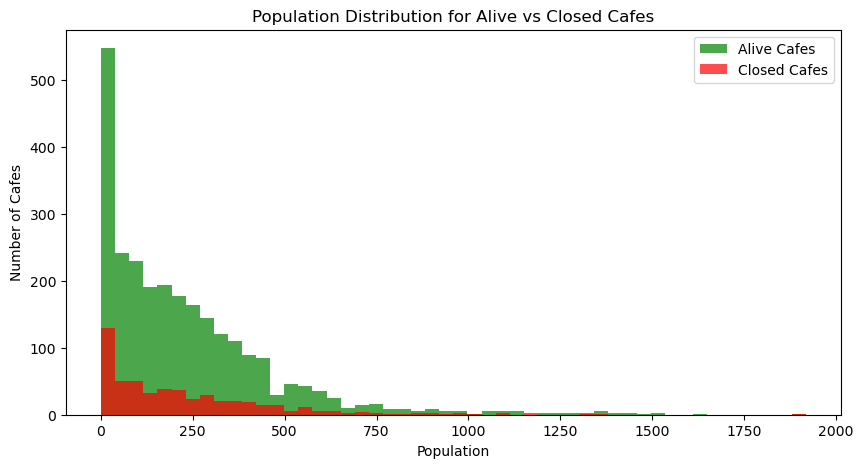

In [26]:
# 인구수가 0인 카페는 제외
filtered_cafe_gdf = cafe_gdf[cafe_gdf["population"] > 0]

# 살아있는 카페와 폐업한 카페로 분리
alive_population = filtered_cafe_gdf.loc[filtered_cafe_gdf["is_alive"] == 1, "population"]
closed_population = filtered_cafe_gdf.loc[filtered_cafe_gdf["is_alive"] == 0, "population"]


# 기술통계 출력
print("살아있는 카페의 population 기술통계:")
print(alive_population.describe())
print("\n폐업한 카페의 population 기술통계:")
print(closed_population.describe())

plt.figure(figsize=(10, 5))
plt.hist(alive_population, bins=50, alpha=0.7, label="Alive Cafes", color="green")
plt.hist(closed_population, bins=50, alpha=0.7, label="Closed Cafes", color="red")
plt.xlabel("Population")
plt.ylabel("Number of Cafes")
plt.title("Population Distribution for Alive vs Closed Cafes")
plt.legend()
plt.show()



In [27]:
cafe_gdf.drop(columns="geometry").to_csv("cafe_with_populationj.csv", index=False, encoding="utf-8")